1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [20]:
from scipy import stats
def Ztest(x, mean, sigma):
    Z = abs(x - mean) / sigma
    p_value = 1 - stats.norm.cdf(Z)
    print("Z value:", Z, "\np-value: %.3f" % p_value, ", significantly different:", "YES" if p_value < 0.05 else "NO")
    return
    
Ztest(15, 6.3, 6.3**0.5)

Z value: 3.4661629670697414 
p-value: 0.000 , significantly different: YES


2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [24]:
import numpy as np
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])

def Ttest(x1, x2, sigma1, sigma2, n):
    sigma = ( (sigma1**2 + sigma2**2) / 2 )**0.5
    T = abs(x1-x2)/(sigma*(2/n)**0.5)
    p_value = stats.t.cdf(-T, n - 1) + (1. - stats.t.cdf(T, n - 1))
    print("T value:", T, "\np-value: %.3f" % p_value, ", statistically significant:", "YES" if p_value < 0.05 else "NO")
    return

Ttest(pre.mean(), post.mean(), pre.std(), post.std(), pre.size)

T value: 3.991846326292112 
p-value: 0.003 , statistically significant: YES


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

lynx period: 10.5 , hare period: 10.5


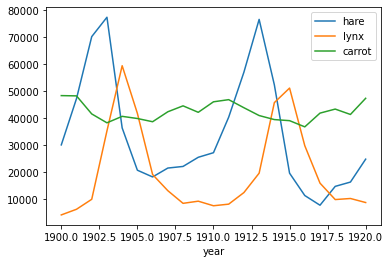

In [69]:
import pandas as pd
from scipy import fftpack

df = pd.read_csv('populations.txt', sep='\t', comment='#', names=('year', 'hare', 'lynx', 'carrot'))
df.plot(x='year')

lynx_fft = fftpack.fft(df['lynx'].to_numpy())
hare_fft = fftpack.fft(df['hare'].to_numpy())
sample_freq = fftpack.fftfreq(lynx_fft.size, d=1)


pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
lynx_w = np.abs(lynx_fft[pos_mask])
hare_w = np.abs(hare_fft[pos_mask])
lynx_period = freqs[lynx_w.argmax()]**(-1)
hare_period = freqs[hare_w.argmax()]**(-1)
print("lynx period:", lynx_period, ", hare period:", hare_period)

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

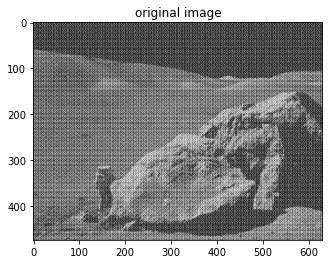

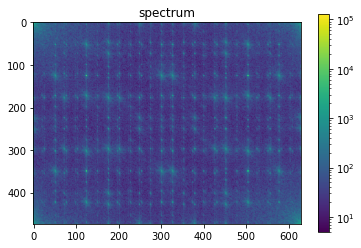

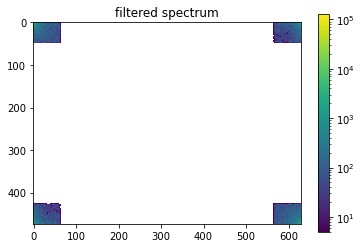

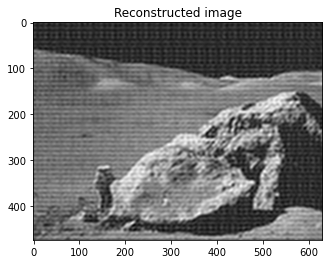

In [284]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

image = plt.imread("data/moonlanding.png")
r, c = image.shape
keep=0.1
plt.imshow(image, plt.cm.gray)
plt.title('original image')
plt.show()
image_fft = fftpack.fft2(image)
power = np.abs(image_fft)
plt.imshow(power, norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('spectrum')
plt.show()
mask = np.where(power)
mask_list = [i for i in range(mask[0].size) if ((mask[0][i] > keep*r and mask[0][i] < (1-keep)*r) or (mask[1][i] > keep*c and mask[1][i] < (1-keep)*c))] 
maskk = np.where(power)
mask1 = mask[0][mask_list]
mask2 = mask[1][mask_list]
mask = (mask1, mask2)
maskk = np.where(power < 50)
filtered_pow = power.copy()
filtered_pow[mask] = 0
filtered_pow[maskk] = 0
plt.imshow(filtered_pow, norm=LogNorm(vmin=5))
plt.title('filtered spectrum')
plt.colorbar()
plt.show()

filtered_im_fft = image_fft.copy()
filtered_im_fft[mask] = 0
filtered_im_fft[maskk] = 0

filtered_im = fftpack.ifft2(filtered_im_fft).real
plt.figure()
plt.imshow(filtered_im, plt.cm.gray)
plt.title('Reconstructed image')
plt.savefig('reconstructed_image.png', dpi=1080)
plt.show()